In [14]:
import sys
sys.path.insert(0, './src/yelp_prediction')

In [15]:
import polars as pl
import dataframes as df
import matplotlib.pyplot as plt

In [16]:
(df_restaurants, df_reviews, df_photos, df_photos_by_business, df_features) = (
    pl.collect_all(
        (
            df.q_restaurants,
            df.q_reviews,
            df.q_photos,
            df.q_photos_agg,
            df.q_features,
        )
    )
)

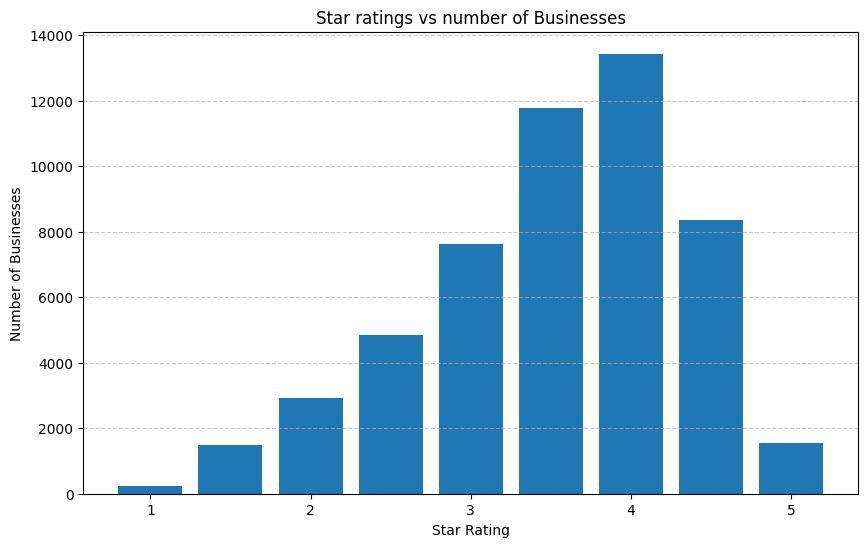

In [17]:
stars_dist = df_restaurants.group_by("stars").len().sort("stars")

plt.figure(figsize=(10, 6))
plt.bar(
    x=stars_dist["stars"],
    height=stars_dist["len"],
    width=0.4,
)
plt.title("Star ratings vs number of Businesses")
plt.xlabel("Star Rating")
plt.ylabel("Number of Businesses")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

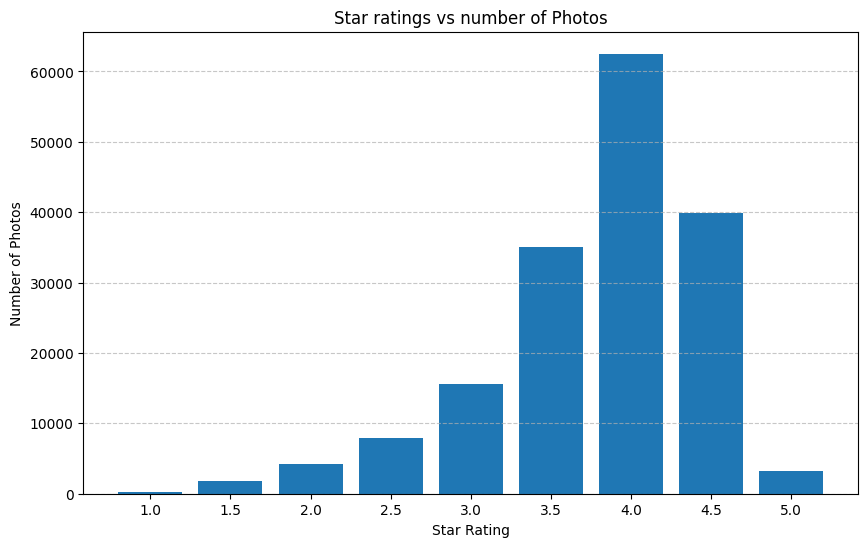

In [18]:
stars_per_photos = (
    df_photos.join(df_restaurants, on="business_id")
    .group_by("stars")
    .agg(pl.len())
    .sort(by="stars")
)

plt.figure(figsize=(10, 6))
plt.bar(
    x=stars_per_photos["stars"],
    height=stars_per_photos["len"],
    width=0.4,
)
plt.title("Star ratings vs number of Photos")
plt.xlabel("Star Rating")
plt.ylabel("Number of Photos")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

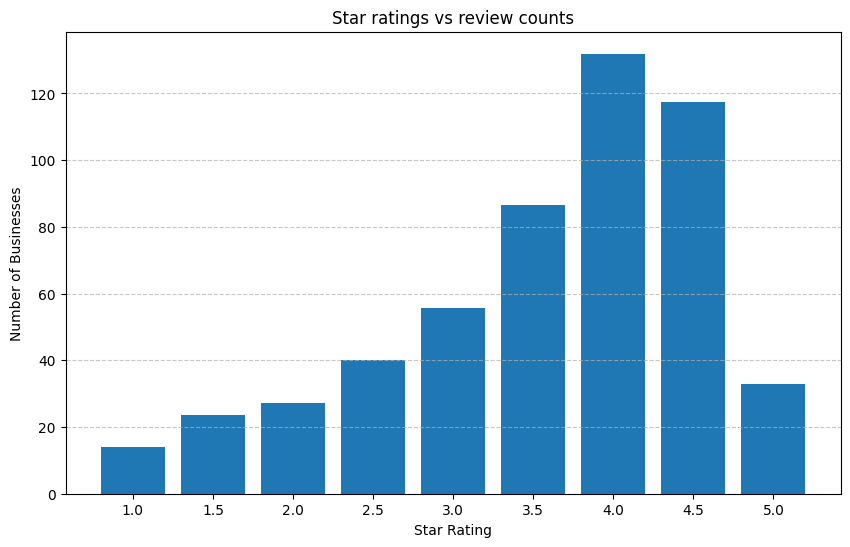

In [19]:
stars_per_photos = (
    df_restaurants.group_by("stars")
    .agg(
        pl.col("review_count").mean(),
    )
    .sort(by="stars")
)

plt.figure(figsize=(10, 6))
plt.bar(
    x=stars_per_photos["stars"],
    height=stars_per_photos["review_count"],
    width=0.4,
)
plt.title("Star ratings vs review counts")
plt.xlabel("Star Rating")
plt.ylabel("Number of Businesses")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

Pearson Correlation: 0.1658
Spearman Correlation: 0.2182


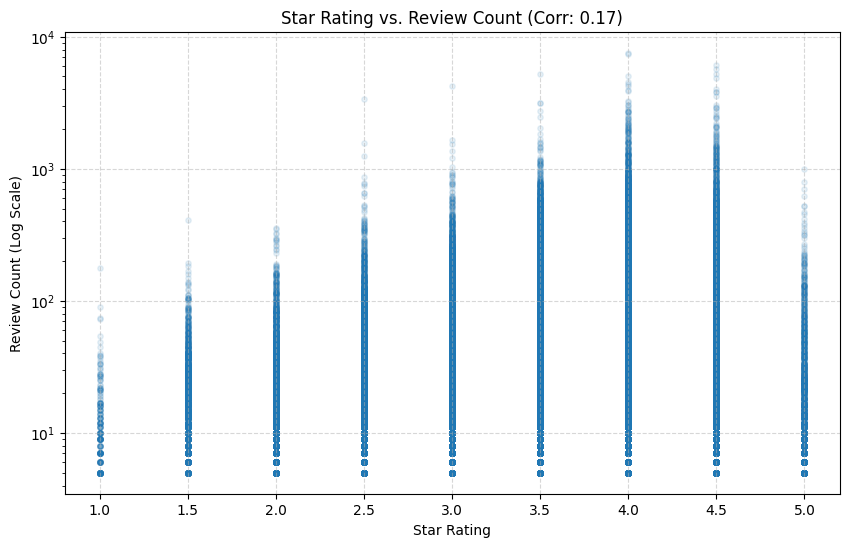

In [20]:
corr_pearson = df_features.select(  #
    pl.corr("stars", "review_count", method="pearson")
).item()
corr_spearman = df_features.select(
    pl.corr("stars", "review_count", method="spearman")
).item()
print(f"Pearson Correlation: {corr_pearson:.4f}")
print(f"Spearman Correlation: {corr_spearman:.4f}")

plt.figure(figsize=(10, 6))

# alpha=0.1 is critical to see density where points overlap
plt.scatter(
    x=df_restaurants["stars"],
    y=df_restaurants["review_count"],
    alpha=0.1,
    s=15,
)

plt.yscale("log")  # Essential: Review counts follow a Power Law
plt.title(f"Star Rating vs. Review Count (Corr: {corr_pearson:.2f})")
plt.xlabel("Star Rating")
plt.ylabel("Review Count (Log Scale)")

plt.grid(True, linestyle="--", alpha=0.5);

In [21]:
df_restaurants_with_photos = df_restaurants.join(
    df_photos_by_business,
    on="business_id",
    how="left",
).select(
    pl.col("business_id"),
    pl.col("stars"),
    pl.col("review_count"),
    pl.col("photo_count").fill_null(0),
)

In [22]:
df_restaurants_with_photos.group_by(
    (pl.col("photo_count") > 0).alias("has_photo")
).agg(
    [
        pl.len().alias("count"),
        pl.col("stars").mean().alias("avg_rating"),
        pl.col("stars").median().alias("median_rating"),
        pl.col("stars").std().alias("std"),
    ]
)

has_photo,count,avg_rating,median_rating,std
bool,u32,f64,f64,f64
false,22894,3.376103,3.5,0.864702
true,29374,3.623562,4.0,0.78426


Correlation (Stars vs Photos): 0.1349


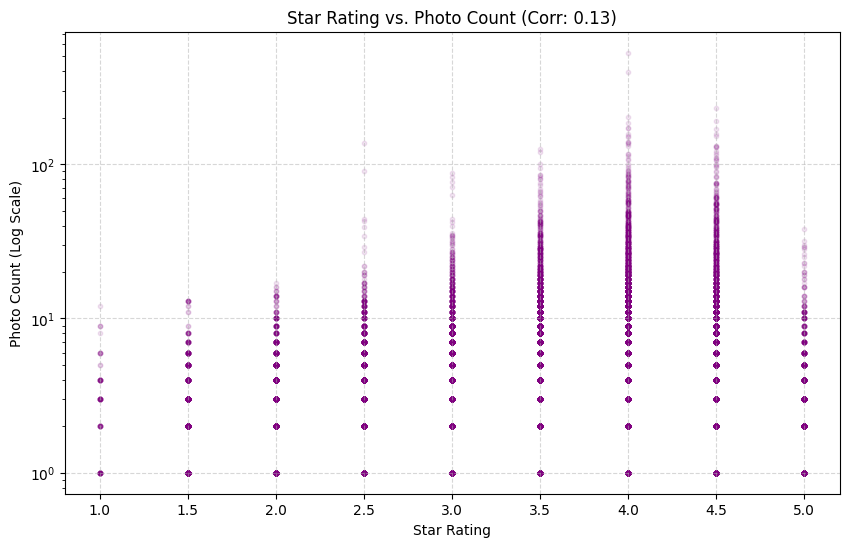

In [ ]:
# Calculate Correlation
corr = df_restaurants_with_photos.select(pl.corr("stars", "photo_count")).item()

print(f"Correlation (Stars vs Photos): {corr:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(
    x=df_restaurants_with_photos["stars"].to_list(),
    y=df_restaurants_with_photos["photo_count"].to_list(),
    alpha=0.1,
    s=10,
    color="purple",
)

plt.yscale("log")
plt.title(f"Star Rating vs. Photo Count (Corr: {corr:.2f})")
plt.xlabel("Star Rating")
plt.ylabel("Photo Count (Log Scale)")

plt.grid(True, linestyle="--", alpha=0.5);